In [54]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from pathlib import Path
from typing import List, Dict, Any, Set
from venny4py import venny4py
from itertools import combinations
from matplotlib.font_manager import findSystemFonts, fontManager
from pprint import pprint

font_path ='/usr/share/fonts/Virgil.ttf' 

# Register the font
fontManager.addfont(font_path)
fonts = set(f.name for f in fontManager.ttflist)

In [3]:
def filter_corrupt_files(paths: List[Path]) -> (List[Dict[str, Any]], List[str]):
    """
    Filter out files that are not valid json files
    """
    data = {}
    corrupt_files = []
    for path in paths:
        try:
            with open(path, "r") as f:
                single_result = json.load(f)
            data[path.name] = single_result
        except json.decoder.JSONDecodeError:
            corrupt_files.append(path.name)
    return data, corrupt_files

In [4]:
# import Biomedical's data

paths = "../data/biomedical_0.13.1.1/"

data_biomed, corrupt_biomed = filter_corrupt_files([Path(paths) / file for file in os.listdir(paths)])

print("Corrupt: ", corrupt_biomed)

Corrupt:  []


In [5]:
# import PyPI data

paths = "../data/pypi_0.13.1.1/"

data_pypi, corrupt_pypi = filter_corrupt_files([Path(paths) / file for file in os.listdir(paths)])

print("Corrupt: ", corrupt_pypi)

Corrupt:  []


In [6]:
# Example data with no Python code - written in R
data_biomed["markerGeneProfile.json"]

{'metadata': {'project_name': 'markerGeneProfile',
  'fawltydeps_version': '0.13.1.1',
  'repo_url': 'https://:@github.com/PavlidisLab/markerGeneProfile.git',
  'creation_timestamp': '2024-01-29T12:23:58.575464'},
 'code_dirs': None,
 'deps_file': [],
 'imports': []}

## Explore types of dependency declaration

### Identify Python projects

1473/1863 are Python projects
785/1473 have dependency declaration file present

In [7]:
785/1473


0.5329260013577732

In [41]:
def get_python_projects(data: Dict[str, Dict[str, Any]] = data_biomed) -> Set[str]:
    codedirs = defaultdict(dict)
    for k, d in data.items():
        if d["code_dirs"]:
            for folder, source_type_dict in d["code_dirs"].items():
                if folder.lower() == d["metadata"]["project_name"].lower():
                    codedirs[d["metadata"]["project_name"]] |= {("PROJECT_NAME", "py"): source_type_dict["py"], ("PROJECT_NAME","ipynb"): source_type_dict["ipynb"]}
                else:
                    codedirs[d["metadata"]["project_name"]] |= {(folder, "py"): source_type_dict["py"], (folder,"ipynb"): source_type_dict["ipynb"]}

    df_codedirs = pd.DataFrame.from_dict(codedirs, orient="index")

    python_projects = set(df_codedirs.index)
    print("Number of Python projects: ", len(python_projects))
    return python_projects

In [47]:
def get_depsfiles(data):
    python_data = get_python_projects(data)
    depsfiles = defaultdict(list)
    for d in data.values():
        if d["metadata"]["project_name"] in python_data:
            if d["deps_file"]:
                depsfiles[d["metadata"]["project_name"]] = d["deps_file"]

    print(len(depsfiles))
    return depsfiles

In [48]:
depsfiles_biomed = get_depsfiles(data_biomed)
depsfiles_pypi = get_depsfiles(data_pypi)
{d["parser_choice"] for k, dd in depsfiles_biomed.items() for d in dd if d["deps_count"] > 0}

Number of Python projects:  1473
785
Number of Python projects:  573
573


{'pyproject.toml', 'requirements.txt', 'setup.cfg', 'setup.py'}

In [1]:
785/1473


0.5329260013577732

In [50]:
# find all parser choices where deps_count > 0
def get_parser_choices(depsfiles):
    parser_choices = defaultdict(dict)
    for k, dd in depsfiles.items():
        _pc = defaultdict(int)
        for d in dd:
            if d["deps_count"] > 0:
                _pc[d["parser_choice"]] += d["deps_count"]
        parser_choices[k] = _pc
    return parser_choices

parser_choices_biomed = get_parser_choices(depsfiles_biomed)
parser_choices_pypi = get_parser_choices(depsfiles_pypi)    

In [51]:
requirements_declaration_methods_biomed_df = pd.DataFrame.from_dict(
    parser_choices_biomed, orient="index").sort_values(by="requirements.txt", ascending=False) > 0

requirements_declaration_methods_pypi_df = pd.DataFrame.from_dict(
    parser_choices_pypi, orient="index").sort_values(by="requirements.txt", ascending=False) > 0


In [60]:
def get_declaration_files_dictionary(requirements_declaration_methods_df):
    set_requirements = set(requirements_declaration_methods_df[requirements_declaration_methods_df["requirements.txt"]].index)
    set_pyproject_toml = set(requirements_declaration_methods_df[requirements_declaration_methods_df["pyproject.toml"]].index)
    set_setup_py= set(requirements_declaration_methods_df[requirements_declaration_methods_df["setup.py"]].index)
    set_setup_cfg= set(requirements_declaration_methods_df[requirements_declaration_methods_df["setup.cfg"]].index)


    requirements_sets = {"requirements.txt": set_requirements,
                "pyproject.toml": set_pyproject_toml,
                "setup.py": set_setup_py,
                "setup.cfg": set_setup_cfg}
    
    return requirements_sets
# venny4py.venny4py(sets={"requirements.txt": set_requirements, "pyproject.toml": set_pyproject_toml, "setup.py": set_setup_py, "setup.cfg": set_setup_cfg})

In [94]:
def convert2bars(declaration_files_dictionary, norm):
    data4bars =  declaration_files_dictionary | \
                    {f"{k1} & {k2}": v1 & v2 for (k1,v1), (k2,v2) in combinations(declaration_files_dictionary.items(), 2)} |\
                    {f"{k1} & {k2} & {k3}": v1 & v2 & v3 for (k1,v1), (k2,v2), (k3,v3) in combinations(declaration_files_dictionary.items(), 3)} |\
                    {f"all": v1 & v2 & v3 & v4 for (_,v1), (_,v2), (_,v3), (_,v4) in combinations(declaration_files_dictionary.items(), 4)}
    
    ddd = {k: np.round(len(v)/norm * 100) for k, v in data4bars.items()}
    return ddd
                
bars_biomed = convert2bars(get_declaration_files_dictionary(requirements_declaration_methods_biomed_df), norm=785)
bars_pypi = convert2bars(get_declaration_files_dictionary(requirements_declaration_methods_pypi_df), norm=573)
len(bars_biomed), len(bars_pypi)

(15, 15)

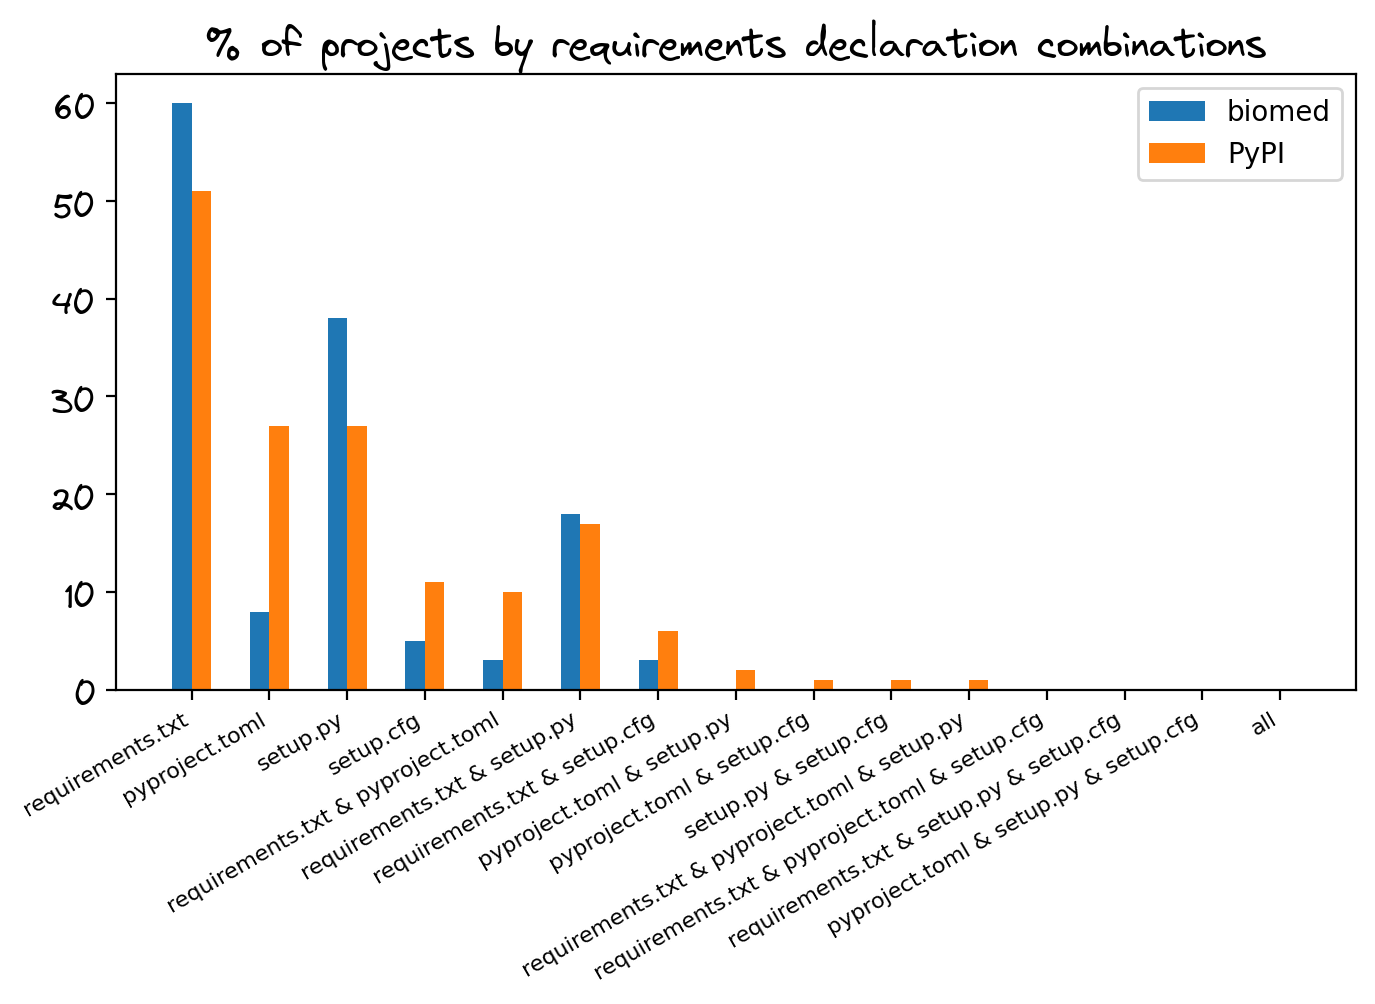

In [95]:

# plot bar plot based on data4bars

fig, ax = plt.subplots()
plt.yticks(fontname='Virgil 3 YOFF', fontsize=12)
plt.title('% of projects by requirements declaration combinations', fontname='Virgil 3 YOFF', fontsize=14)

r=np.arange(15)
width=0.25
# set figure sizxe
fig.set_size_inches(8, 4)
# rotate x ticks
plt.xticks(r+width/2, bars_biomed.keys(), rotation=30, ha='right', fontsize=8)
ax.bar(r,  bars_biomed.values(), label="biomed", width=width)
#make second bars adjascent to the first
ax.bar(r+width, bars_pypi.values(), label="PyPI", width=width)
plt.legend()